Exercise 2: Train a VAE to generate images similar to the images of the given fashion-mnist dataset. 

The dataset is given in two csv files (train and test). ALL data should be used to train the VAE. The csv files have headers, their first columns contain labels, and the remaining columns contain image data.

Your should: write dataloaders, train an appropriate VAE, show a few samples and their corresponding decoded images, as well as a few of the generated samples.


In [1]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Datas(Dataset):
  def __init__(self, data, transform=None):
    super().__init__()

    self.images = data.iloc[:, 1:].to_numpy().astype(np.float32).reshape(-1,28,28)/255

    self.labels = data.iloc[:, 0].to_numpy()
    
    self.transform = transform 

    
  def __len__(self,test=False):
    return len(self.test_imagess) if test else len(self.images)

  def __getitem__(self, index):
    # if not test:
    image = self.images[index]
    image = torch.tensor(np.expand_dims(image, axis=0))
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.labels[index])
    return image, label

In [4]:


train_df = pd.read_csv('/content/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashion-mnist_test.csv')
train = pd.concat((test_df, train_df), axis = 0)

trainset=Datas(train)
batch_size = 64
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                         batch_size=batch_size, shuffle=True)


In [5]:
class VarAutoEncoder(nn.Module):
  def __init__(self, nz=32):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16,3,2,1)
    self.edrop1=nn.Dropout2d(p=0.3)
    self.ebn1 = nn.BatchNorm2d(16)
    self.edrop1=nn.Dropout2d(p=0.3)
    self.econv2 = nn.Conv2d(16, 32, 3,2,1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32,64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*4*4, 128)
    self.ebn4 = nn.BatchNorm1d(128)
    
    self.dlinear1 = nn.Linear(nz,128)
    self.dbn1 = nn.BatchNorm1d(128)
    self.ddrop1=nn.Dropout(p=0.4)
    self.dlinear2 = nn.Linear(128,64*4*4)
    self.dbn2 = nn.BatchNorm2d(64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.ddrop2=nn.Dropout2d(p=0.3)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding =1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding =1)
    
    self.ulinear = nn.Linear(128,nz)
    self.slinear = nn.Linear(128,nz)


  def encoder (self,x):
    x = F.leaky_relu(self.econv1(x))
    x = self.ebn1(x)
    x=self.edrop1(x)
    x = F.leaky_relu(self.econv2(x))
    x = self.ebn2(x)
    x=self.edrop1(x)
    x = F.leaky_relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,64*4*4)
    x = F.leaky_relu(self.elinear1(x))
    x = self.ebn4(x)
    return x
  
  def decoder(self, x):
    x = F.leaky_relu(self.dlinear1(x))
    x = self.dbn1(x)
    x=self.ddrop1(x)
    x = F.leaky_relu(self.dlinear2(x))
    x = x.view(-1, 64,4,4)
    x = self.dbn2(x)
    x = F.leaky_relu(self.dconv1(x))
    x = self.dbn3(x)
    x=self.ddrop2(x)
    x = F.leaky_relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x

  def get_params(self,x):
    u = self.ulinear(x)
    logvar = self.slinear(x)
    return u, logvar

  def reparametarization(self, u, logvar):
    std = torch.exp(logvar/2)
    z = u + std*torch.randn_like(u)
    return z

  def forward(self,x):
    ex = self.encoder(x)
    u, logvar = self.get_params(ex)
    z = self.reparametarization(u, logvar)
    x = self.decoder(z)
    return ex,z, x, u, logvar 

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
'''net = VarAutoEncoder(32).to(device)

summary(net, (1, 28, 28))'''

'net = VarAutoEncoder(32).to(device)\n\nsummary(net, (1, 28, 28))'

0 66.06775030121207
1 48.162461422383785
2 43.47301892191172
3 41.60842826962471
4 40.560901287943125
5 39.98706419765949
6 39.55865328013897
7 39.20796616002917
8 38.967508947476745
9 38.82807142473757
10 38.642954071983695
11 38.4472315851599
12 38.355663903057575
13 38.23036809824407
14 38.171774135902524
15 38.07111392356455
16 37.986001029610634
17 37.83655725419521
18 37.807813327759504
19 37.73746966943145


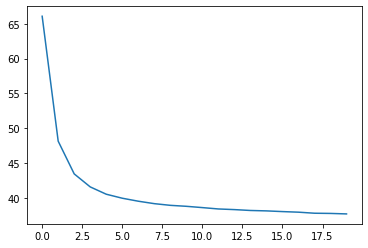

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = VarAutoEncoder(128).to(device)

num_epochs = 20
lr = 0.001
mm = 0.5

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []

def var_loss(Xhat, X, u, logvar):
  KLD_WEIGHT = 0.0012
  term1 = F.mse_loss(Xhat, X)
  term2 = torch.mean(torch.sum(0.5*(1+logvar - torch.exp(logvar) - u**2), axis = 1), axis =0)
  return (1- KLD_WEIGHT)* term1 - KLD_WEIGHT*term2

for epoch in range(num_epochs):
  total_loss = 0
  for batch in trainloader:
    X = batch[0].to(device)
    ex, z,Xhat, u, logvar = net(X)
    
    loss = var_loss(Xhat, X,u, logvar )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(epoch, total_loss)

  ls.append(total_loss)

plt.plot(ls)


In [9]:
net.eval()
z = torch.randn(64,128)
Xhat = net.decoder(z.to(device))

torch.Size([64, 1, 28, 28]) torch.Size([28, 28]) torch.float32


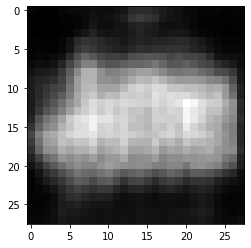

In [10]:
img = Xhat[0, 0]
print(Xhat.shape, img.shape, img.dtype)
plt.imshow(img.detach().cpu().numpy(), cmap='gray')


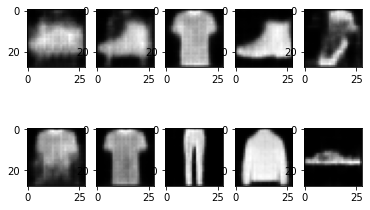

In [11]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy(),cmap='gray')